## Анализ полученных данных

Статистика по вакансиям для удобного отображения вынесена в отдельную тетрадку.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import re

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set()

C:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### Загрузка данных

In [2]:
df = pd.read_csv('hh_results.csv')
df.head()

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
0,50880086,Домклик,Data analyst/data engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Базы данных',...",Мы - это продуктовая IT компания по созданию h...
1,50439267,NXP Semiconductors,Data Engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'Linux', 'English', 'TCL', 'Data En...",NXP Semiconductors N.V. (NASDAQ: NXPI) enables...
2,51056512,ПИК-БРОКЕР,Data Engineer,True,150000.0,250000.0,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Git', 'Airflow']",Мы - ПИК-Брокер - молодая и очень динамично ра...
3,50657338,COMTEK Inc.,Data Scientist,False,NaN,NaN,От 3 до 6 лет,Полный день,"['Python', 'SQL', 'Power BI', 'Английский язык...",Подбираем команду для крупной американской ком...
4,50439196,Медиа Бизнес Солюшенс,Data scientist,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'PostgreSQL', 'Tensorflow', 'sklear...","М3 — компания, которая занимается развитием ци..."


### Количество вакансий

In [3]:
df['Name'] = df.Name.str.lower()

In [4]:
df['Name'] = df.Name.apply(lambda x:'data engineer' if 'data engineer' in x else x)

In [5]:
df['Name'] = df.Name.apply(lambda x:'data scientist' if 'data scientist' in x else x)

In [6]:
for i in ('product analyst', 'аналитик данных', 'продуктовый аналитик', 'data analyst'):
    df['Name'] = df.Name.apply(lambda x:'data analyst' if i in x else x)

In [7]:
da_de_ds = df[
              (df.Name.str.contains('data engineer')) | \
              (df.Name.str.contains('data analyst')) | \
              (df.Name.str.contains('data scientist'))  
             ]

In [8]:
da_de_ds.Name.value_counts()

data engineer     303
data scientist    235
data analyst      231
Name: Name, dtype: int64

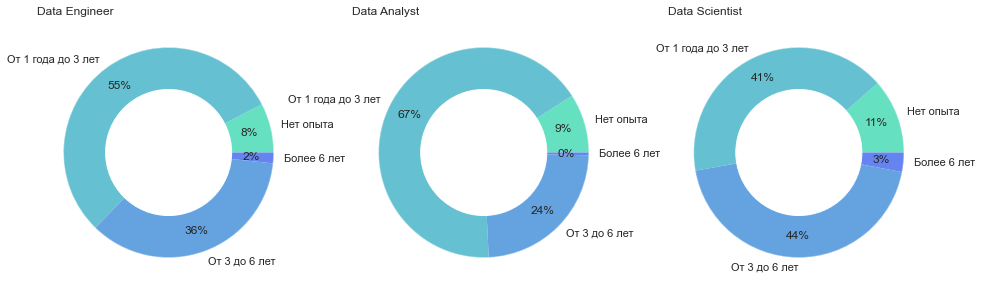

In [24]:
def get_level_stats(data, category):
    level_stats ={
        'Нет опыта': df[(df.Name.str.contains(category)) & (df.Experience == 'Нет опыта')].Ids.count(),
        'От 1 года до 3 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 1 года до 3 лет')].Ids.count(),
        'От 3 до 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 3 до 6 лет')].Ids.count(),
        'Более 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'Более 6 лет')].Ids.count(),
    }
    return level_stats
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data engineer')
ax1.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax1.add_artist(centre_circle)
ax1.add_artist(centre_circle1)
ax1.set_title('Data Engineer', size=12, loc='left')

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data analyst')
ax2.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax2.add_artist(centre_circle)
ax2.add_artist(centre_circle1)
ax2.set_title('Data Analyst', size=12, loc='left')


centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data scientist')
ax3.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax3.add_artist(centre_circle)
ax3.add_artist(centre_circle1)
ax3.set_title('Data Scientist', size=12, loc='left')
plt.show()

### Зарплаты в Data Science

In [20]:
salary = da_de_ds[(da_de_ds.From.notnull()) | (da_de_ds.To.notnull())]

In [28]:
salary = salary[salary['Experience'] != 'Более 6 лет'].sort_values(by='Experience')

In [29]:
salary['mean_salary'] = salary[['From', 'To']].apply(lambda x: x[0] if np.isnan(x[1])\
                                              else (x[1] if np.isnan(x[0]) else (x[0] + x[1])/2), axis=1)

In [30]:
fig = px.box(salary, x="Experience", y="mean_salary", color='Name', labels={
             "mean_salary": "Уровень зарплат в тыс. рублях",
             "Experience": "Уровень",
             "Name": "Специальность"
         }, title = 'Распределение зарплат по грейдам')
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.show()